In [1]:
# 使有現有道瓊2010-2019年1分鐘資料
with open('10Y.txt', 'r', encoding="UTF-8") as f:
    data = f.readlines()
    print(data[:10])
f.close()

['2010/1/3,17:01:00,8334.000000,8352.000000,8334.000000,8348.000000,80\n', '2010/1/3,17:02:00,8348.000000,8349.000000,8346.000000,8349.000000,15\n', '2010/1/3,17:03:00,8347.000000,8349.000000,8346.000000,8347.000000,14\n', '2010/1/3,17:04:00,8349.000000,8349.000000,8347.000000,8347.000000,3\n', '2010/1/3,17:05:00,8346.000000,8350.000000,8345.000000,8350.000000,9\n', '2010/1/3,17:06:00,8349.000000,8349.000000,8349.000000,8349.000000,1\n', '2010/1/3,17:07:00,8350.000000,8353.000000,8350.000000,8352.000000,23\n', '2010/1/3,17:08:00,8349.000000,8349.000000,8349.000000,8349.000000,1\n', '2010/1/3,17:09:00,8350.000000,8350.000000,8350.000000,8350.000000,1\n', '2010/1/3,17:11:00,8351.000000,8354.000000,8351.000000,8354.000000,3\n']


In [ ]:
# 將原始資料導入MySQL
'''
1.先創建資料庫
  creata databases futures
  use futures
  
2.創建表
  create table futures10Y(
  day(date),
  time(time),
  open(decimal),
  high(decimal),
  low(decimal),
  close(decimal),
  vol(decimal));
  
3.將原始資料導入MySQL
  sudo cp 10Y.txt /var/lib/mysql-files/
  load data infile '/var/lib/mysql-files/10Y.txt'
  into table futures10Y
  field terminated by ','
  lines terminated by '\n';
'''

In [ ]:
# 將MySQL 資料導出並使用pandas將資料轉換成15分及30分
import pymysql
import pandas as pd

# 將日期時間合併之函數
def CombinDate(data):
    L = []
    df_copy = data.copy()
    for i in range(len(df_copy)):
        dtime = dt.datetime.strptime(df_copy['day'][i] + " " + df_copy['time'][i], '%Y/%m/%d %H:%M:%S')
        L.append(dtime)
    df1 = pd.DataFrame({'dtime': L})
    df2 = data.drop({'day', 'time', 'vol'}, axis=1)
    df3 = pd.concat([df1, df2], axis=1)
    return df3

# 建立連接資料庫
db = pymysql.connect(host='localhost', user='root',
                    password='a123456', database='futures',
                    charset='utf8')

sql = 'select * from futures10y'
df = pd.read_sql(sql, con=db)

# 日期時間合併
combindate = CombinDate(date)
combindate = combindate.set_index('dtime')

# 篩選15分鐘開高低收
data_15T = combindate.resample('15T').last()
data_15T['open'] = combindate['open'].resample('15T').first()
data_15T['high'] = combindate['high'].resample('15T').max()
data_15T['low'] = combindate['low'].resample('15T').min()

# 刪除有Nan值得列
data_15T.dropna(axis=0, how='any', inplace=True)

# 15分鐘資料儲存為csv
data_15T.to_csv("15T_10Y.csv")


# 篩選30分鐘開高低收
data_30T = combindate.resample('30T').last()
data_30T['open'] = combindate['open'].resample('30T').first()
data_30T['high'] = combindate['high'].resample('30T').max()
data_30T['low'] = combindate['low'].resample('30T').min()

# 刪除有Nan值得列
data_30T.dropna(axis=0, how='any', inplace=True)

# 15分鐘資料儲存為csv
data_30T.to_csv("30T_10Y.csv")

In [2]:
import pandas as pd

# 取得15分鐘資料內容
data = pd.read_csv("15T_10Y.csv")
data.head()

,dtime,open,high,low,close
0,2010-01-03 17:00:00,8348.0,8354.0,8345.0,8354.0
1,2010-01-03 17:15:00,8354.0,8364.0,8353.0,8363.0
2,2010-01-03 17:30:00,8363.0,8364.0,8352.0,8357.0
3,2010-01-03 17:45:00,8357.0,8359.0,8356.0,8357.0
4,2010-01-03 18:00:00,8359.0,8365.0,8358.0,8364.0


請輸入資料檔名:30T_10Y.csv


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


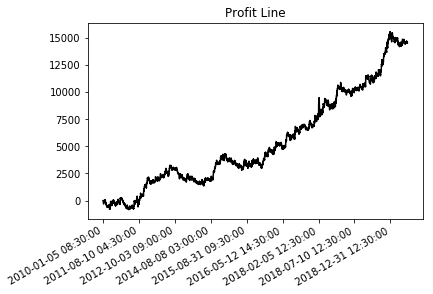

        所有交易
交易總筆數   4238
勝率      0.38
獲利因子    1.13
總淨利    14511


In [1]:
# 交易策略_1（移動停損, 資料:30分鐘）
import matplotlib.pyplot as mp
import matplotlib.dates as md
import datetime as dt
import pandas as pd
%matplotlib inline 

# 取得資料內容
fn = input("請輸入資料檔名:")
data = pd.read_csv(fn)

# 停損
StopLoss = 30

# 預設庫存
index = 0

TotalProfit = [0]
TotalProfit2 = [0]
Time = []

# 策略:移動停損停利
for m in range(1, len(data)):
    thisTime = data['dtime'][m]
    thisClose = data['close'][m]
    lastClose = data['close'][m-1]

    if index == 0:
        if thisClose - lastClose > 30:
            index = 1
            OrderTime = thisTime
            OrderPrice = thisClose
            price = OrderPrice

        elif lastClose - thisClose > 30:
            index = -1
            OrderTime = thisTime
            OrderPrice = thisClose
            price = OrderPrice

    elif index != 0:
        if index == 1:
            TrailingStop = price - 30

            if thisClose - price >= 30:
                price = thisClose
                # 移動停損
                TrailingStop = price - 30

            elif thisClose <= TrailingStop:
                Covertime = thisTime
                Coverprice = thisClose
                Profit = Coverprice - OrderPrice
                TotalProfit.append(TotalProfit[-1] + Profit)
                TotalProfit2.append(Profit)
                Time.append(Covertime)
                index = 0
            else:
                if thisClose <= (OrderPrice - StopLoss):
                    Covertime = thisTime
                    Coverprice = thisClose
                    Profit = Coverprice - OrderPrice
                    TotalProfit.append(TotalProfit[-1] + Profit)
                    TotalProfit2.append(Profit)
                    Time.append(Covertime)
                    index = 0

        elif index == -1:
            TrailingStop = price + 30

            if price - thisClose >= 30:
                price = thisClose
                # 移動停損
                TrailingStop = price + 30
            elif thisClose >= TrailingStop:
                Covertime = thisTime
                Coverprice = thisClose
                Profit = OrderPrice - Coverprice
                TotalProfit.append(TotalProfit[-1] + Profit)
                TotalProfit2.append(Profit)
                Time.append(Covertime)
                index = 0
            else:
                if thisClose >= OrderPrice + StopLoss:
                    Covertime = thisTime
                    Coverprice = thisClose
                    Profit = Coverprice - OrderPrice
                    TotalProfit.append(TotalProfit[-1] + Profit)
                    TotalProfit2.append(Profit)
                    Time.append(Covertime)
                    index = 0

                    
# 定義title
mp.title('Profit Line')

# 定義圖表物件
ax = mp.subplot(111)

# 調整x軸
ax.set_xticks(range(0, len(Time), 500))
ax.set_xticklabels(Time[::500])

# 繪製圖案
#print(TotalProfit)
ax.plot(range(len(TotalProfit)),TotalProfit, 'k-')

# 調整x軸格式
mp.gcf().autofmt_xdate()

# 顯示繪製圖表
mp.show()

# 損益
# 交易筆數
PLtime = len(TotalProfit2)
PLtime = int(PLtime)

# 獲利
V = []
L = []
for i in TotalProfit2:
    if i > 0:
        V.append(i)
    else:
        L.append(i)

# 勝率 = 獲勝次數 / 總筆數
V_rate = len(V) / PLtime
V_rate = "{:.2f}".format(V_rate)

# 總淨利 = 獲利 - 虧損
PL_sum = sum(V) + sum(L)
PL_sum = int(PL_sum)

# 獲利因子 = 總獲利 / -(總虧損)
Profit_rate = sum(V) / -(sum(L))
Profit_rate = "{:.2f}".format(Profit_rate)

alldeal = {'交易總筆數':PLtime, "總淨利": PL_sum, "勝率": V_rate, "獲利因子": Profit_rate}

Total_PL = pd.DataFrame(alldeal, index=[0])
Total_PL = Total_PL.rename(index={0:'所有交易'})
print(Total_PL.T)




請輸入資料檔名:30T_10Y.csv


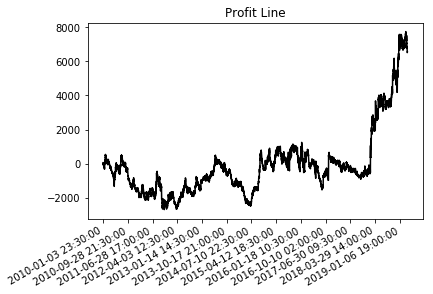

        所有交易
交易總筆數  14765
勝率      0.34
獲利因子    1.03
總淨利     6547


In [2]:
# 交易策略_2（KD + RSI, 資料:30分鐘）
import matplotlib.pyplot as mp
import datetime as dt
import pandas as pd
import fun
from talib.abstract import *

# 取得資料內容
fn = input("請輸入資料檔名:")
data = fun.GetData(fn)
# print(data)

# 停損
StopLoss = 30

# 預設庫存
index = 0

TotalProfit = [0]
TotalProfit2 = [0]
Time = []

# RSI 
S_RSI = RSI(data.close, 6)
L_RSI = RSI(data.close, 12)
# KD值
KD = STOCH(data,fastk_period=9, slowk_period=3, slowd_period=3)

# 策略:KD & RSI
for m in range(1, len(data)):
    thisTime = data['dtime'][m]
    thisClose = data['close'][m]
    lastClose = data['close'][m-1]
    K = KD.slowk[m]
    D = KD.slowd[m]
    RSI_s = S_RSI[m]
    RSI_l = L_RSI[m]

    if index == 0:
        if K > D and RSI_s > RSI_l:
            index = 1
            OrderTime = thisTime
            OrderPrice = thisClose

        elif K < D and RSI_s < RSI_l:
            index = -1
            OrderTime = thisTime
            OrderPrice = thisClose

    elif index != 0:
        if index == 1:
            if K < D and RSI_s < RSI_l:
                Covertime = thisTime
                Coverprice = thisClose
                Profit = Coverprice - OrderPrice
                TotalProfit.append(TotalProfit[-1] + Profit)
                TotalProfit2.append(Profit)
                Time.append(Covertime)
                index = 0

        elif index == -1:
            if K > D and RSI_s > RSI_l:
                Covertime = thisTime
                Coverprice = thisClose
                Profit = OrderPrice - Coverprice
                TotalProfit.append(TotalProfit[-1] + Profit)
                TotalProfit2.append(Profit)
                Time.append(Covertime)
                index = 0

# 定義title
mp.title('Profit Line')

# 定義圖表物件
ax = mp.subplot(111)
# 設定x軸
ax.set_xticks(range(0, len(Time), 1200))
ax.set_xticklabels(Time[::1200])

# 繪製圖案
#print(TotalProfit)
ax.plot(range(len(TotalProfit)),TotalProfit, 'k-')

# 調整x軸格式
mp.gcf().autofmt_xdate()
# 顯示繪製圖表
mp.show()

# 損益
# 交易筆數
PLtime = len(TotalProfit2)
PLtime = int(PLtime)

# 獲利
V = []
L = []
for i in TotalProfit2:
    if i > 0:
        V.append(i)
    else:
        L.append(i)

# 勝率 = 獲勝次數 / 總筆數
V_rate = len(V) / PLtime
V_rate = "{:.2f}".format(V_rate)

# 總淨利 = 獲利 - 虧損
PL_sum = sum(V) + sum(L)
PL_sum = int(PL_sum)

# 獲利因子 = 總獲利 / -(總虧損)
Profit_rate = sum(V) / -(sum(L))
Profit_rate = "{:.2f}".format(Profit_rate)

alldeal = {'交易總筆數':PLtime, "總淨利": PL_sum, "勝率": V_rate, "獲利因子": Profit_rate}

Total_PL = pd.DataFrame(alldeal, index=[0])
Total_PL = Total_PL.rename(index={0:'所有交易'})
print(Total_PL.T)